# Audio Speech Sentiment Recognition
An emotion classifier built using standard audio data processing and deep learning algorithms. Here, we have 4 different datasets with a 12,000+ audio files and a plethora of voice actors to  generalize the model and avoid overfitting over a certain accent. Due to the sheer complexity of SER (Speech Emotion Recognition), the accuracy will be 60-70% only. However. we've tried to give you a brief comparison of various decisions over the accuracy.

Datasets used:
1. Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)
2. Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
3. Surrey Audio-Visual Expressed Emotion (Savee)
4. Toronto emotional speech set (Tess)

Algorithm used: Sequential with 1D convolution layer (Conv1D) & Maxpooling

### 

## Importing Libraries

In [43]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 

## Data Preparation

In [44]:
# Paths for data.
Ravdess = "data/archive/audio_speech_actors_01-24/"
Crema = "data/archive (2)/AudioWAV/"
Tess = "data/archive (1)/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "data/archive (4)/ALL/"

# 

## 1. Ravdess Dataframe

In [45]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append((part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({'01':'neutral', '02':'calm', '03':'happy', '04':'sad', '05':'angry', '06':'fear', '07':'disgust', '08':'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  neutral  data/archive/audio_speech_actors_01-24/Actor_0...
1  neutral  data/archive/audio_speech_actors_01-24/Actor_0...
2  neutral  data/archive/audio_speech_actors_01-24/Actor_0...
3  neutral  data/archive/audio_speech_actors_01-24/Actor_0...
4     calm  data/archive/audio_speech_actors_01-24/Actor_0...

# 

## 2. Crema DataFrame

In [46]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                           Path
0    angry  data/archive (2)/AudioWAV/1001_DFA_ANG_XX.wav
1  disgust  data/archive (2)/AudioWAV/1001_DFA_DIS_XX.wav
2     fear  data/archive (2)/AudioWAV/1001_DFA_FEA_XX.wav
3    happy  data/archive (2)/AudioWAV/1001_DFA_HAP_XX.wav
4  neutral  data/archive (2)/AudioWAV/1001_DFA_NEU_XX.wav

## 

## 3. TESS dataset

In [47]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0    angry  data/archive (1)/TESS Toronto emotional speech...
1    angry  data/archive (1)/TESS Toronto emotional speech...
2    angry  data/archive (1)/TESS Toronto emotional speech...
3    angry  data/archive (1)/TESS Toronto emotional speech...
4    angry  data/archive (1)/TESS Toronto emotional speech...

# 

## 4. CREMA-D dataset

In [48]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                             Path
0    angry  data/archive (4)/ALL/DC_a01.wav
1    angry  data/archive (4)/ALL/DC_a02.wav
2    angry  data/archive (4)/ALL/DC_a03.wav
3    angry  data/archive (4)/ALL/DC_a04.wav
4    angry  data/archive (4)/ALL/DC_a05.wav

## 

In [49]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path = data_path.drop(data_path.index[data_path['Emotions'] == ' Shortcut'])
data_path.to_csv("data_path.csv",index=False)
data_path

Emotions                                               Path
0     neutral  data/archive/audio_speech_actors_01-24/Actor_0...
1     neutral  data/archive/audio_speech_actors_01-24/Actor_0...
2     neutral  data/archive/audio_speech_actors_01-24/Actor_0...
3     neutral  data/archive/audio_speech_actors_01-24/Actor_0...
4        calm  data/archive/audio_speech_actors_01-24/Actor_0...
..        ...                                                ...
475  surprise                   data/archive (4)/ALL/KL_su11.wav
476  surprise                   data/archive (4)/ALL/KL_su12.wav
477  surprise                   data/archive (4)/ALL/KL_su13.wav
478  surprise                   data/archive (4)/ALL/KL_su14.wav
479  surprise                   data/archive (4)/ALL/KL_su15.wav

[12159 rows x 2 columns]

# 

## Exploratory Data Analysis

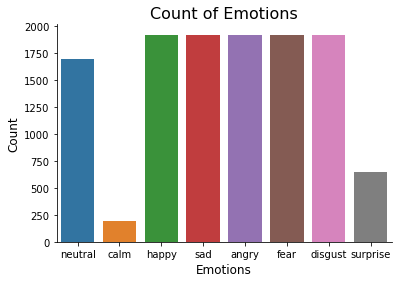

In [13]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# 

### Functions to create waveplots & spectograms, easily

In [50]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

# 

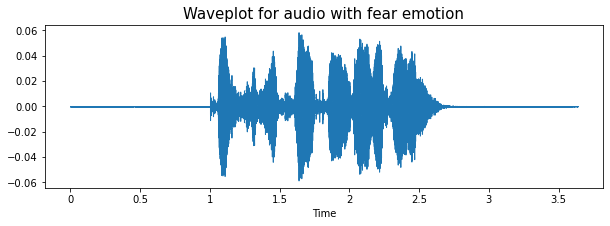

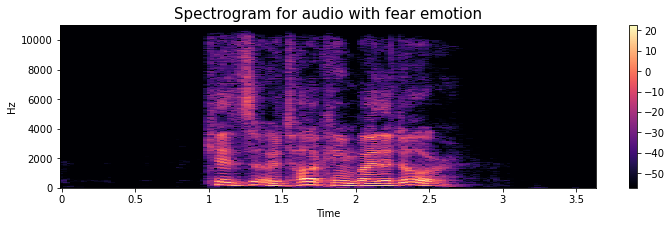

In [9]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# 

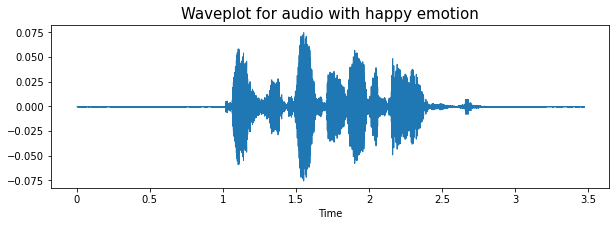

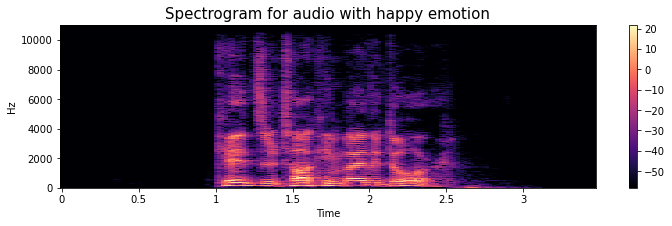

In [730]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# 

# 

## Data Augmentation
Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.

In [51]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

# 

### 1. Simple Audio

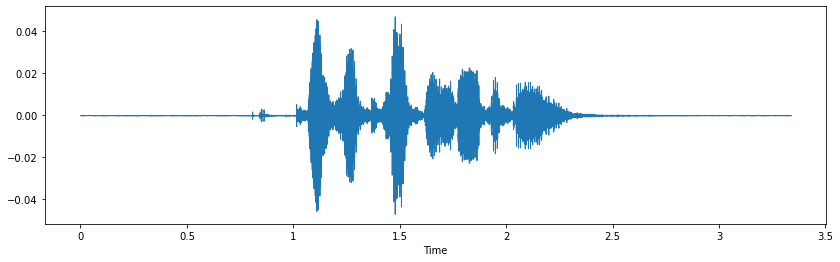

In [11]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

# 

### 2. Noise Injection
Adding noise to a neural network during training can improve the robustness of the network, resulting in better generalization and faster learning. It can make the training process more robust and reduce generalization error.

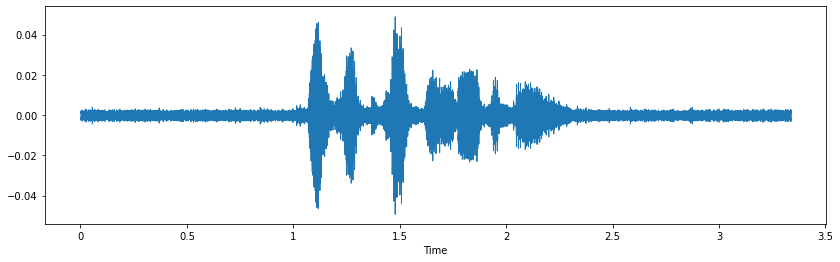

In [12]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# 

### 3. Stretching
The process of changing the speed/duration of sound without affecting the pitch of sound. This can be achieved using librosa’s time_stretch function. Time_stretch function takes wave samples and a factor by which to stretch as inputs. I found that this factor should be 0.8 since it has a small difference with original sample.

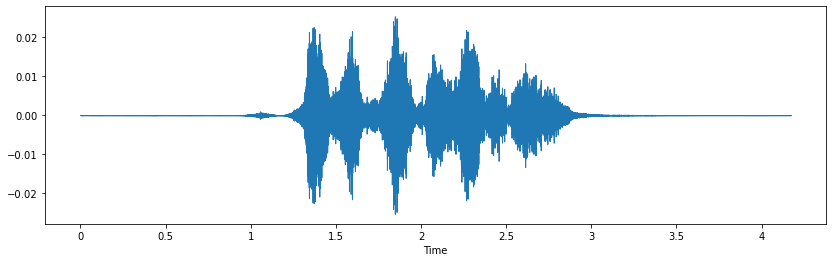

In [13]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# 

### 4. Shifting
It is a process of changing the pitch of sound without affect it’s speed. It takes wave samples, sample rate and number of steps through which pitch must be shifted. I found that number of steps between -5 to 5 are much favorable as per our dataset. 

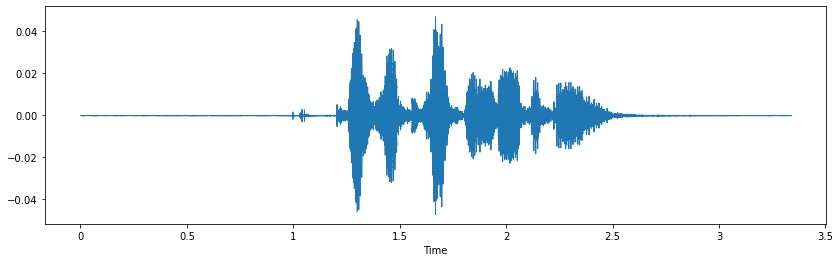

In [14]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# 

### 5. Pitch
It is a process of changing the pitch of sound without affect it’s speed.

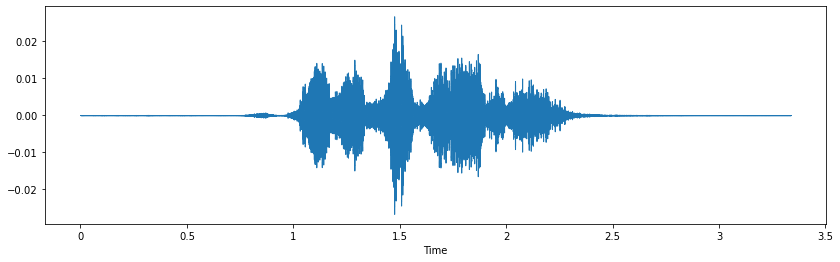

In [15]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# 

## Feature Extraction (THIS PROCESS TAKES TIME)
Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.

In [52]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [27]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [53]:
len(X), len(Y), data_path.Path.shape

(36477, 36477, (12159,))

In [29]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.283226  0.739174  0.760110  0.738748  0.712194  0.687986  0.667279   
1  0.330688  0.826414  0.835283  0.820224  0.834633  0.819741  0.702043   
2  0.181467  0.629995  0.730929  0.743651  0.680889  0.670727  0.673700   
3  0.254530  0.676571  0.724970  0.725722  0.668644  0.645344  0.671471   
4  0.306080  0.773792  0.812476  0.792041  0.769896  0.777697  0.704005   

          7         8         9  ...           153           154  \
0  0.694000  0.742275  0.762594  ...  4.312694e-06  3.293364e-06   
1  0.690190  0.741154  0.780055  ...  1.132534e-04  1.070084e-04   
2  0.669033  0.709932  0.745144  ...  8.582505e-07  9.570446e-07   
3  0.631493  0.681749  0.709889  ...  6.987414e-06  7.038922e-06   
4  0.648020  0.715484  0.746270  ...  5.083443e-05  4.719483e-05   

            155           156           157           158           159  \
0  2.149553e-06  2.260914e-06  4.562520e-06  4.985617e-06  1.324619e-06   
1  1.089942e-04  1.162476e-04  1.135475e-04  1.114004e-04  1.074125e-04   
2  7.741540e-07  5.212421e-07  3.252106e-07  4.883136e-07  2.353670e-07   
3  6.659573e-06  6.937638e-06  1.117492e-05  5.767251e-06  2.024577e-06   
4  4.682496e-05  5.141562e-05  5.280947e-05  4.865155e-05  4.408281e-05   

            160           161   labels  
0  1.469305e-07  3.053402e-09  neutral  
1  1.095854e-04  1.069188e-04  neutral  
2  2.240905e-08  9.753157e-11  neutral  
3  1.944936e-07  2.701240e-09  neutral  
4  4.380759e-05  4.302576e-05  neutral  

[5 rows x 163 columns]

# 

## Data Preparation

In [127]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [128]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [129]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27357, 162), (27357, 8), (9120, 162), (9120, 8))

In [130]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27357, 162), (27357, 8), (9120, 162), (9120, 8))

In [131]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27357, 162, 1), (27357, 8), (9120, 162, 1), (9120, 8))

In [35]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [36]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
428/428 [==============================] - 142s 326ms/step - loss: 1.6609 - accuracy: 0.3201 - val_loss: 1.4576 - val_accuracy: 0.4174 - lr: 0.0010
Epoch 2/100
428/428 [==============================] - 139s 324ms/step - loss: 1.4522 - accuracy: 0.4132 - val_loss: 1.3440 - val_accuracy: 0.4584 - lr: 0.0010
Epoch 3/100
428/428 [==============================] - 139s 325ms/step - loss: 1.3661 - accuracy: 0.4477 - val_loss: 1.3193 - val_accuracy: 0.4686 - lr: 0.0010
Epoch 4/100
428/428 [==============================] - 141s 330ms/step - loss: 1.3054 - accuracy: 0.4778 - val_loss: 1.2024 - val_accuracy: 0.5219 - lr: 0.0010
Epoch 5/100
428/428 [==============================] - 140s 327ms/step - loss: 1.2646 - accuracy: 0.4949 - val_loss: 1.1904 - val_accuracy: 0.5197 - lr: 0.0010
Epoch 6/100
428/428 [==============================] - 140s 327ms/step - loss: 1.2305 - accuracy: 0.5070 - val_loss: 1.1710 - val_accuracy: 0.5340 - lr: 0.0010
Epoch 7/100
428/428 [===================

Epoch 52/100
428/428 [==============================] - 189s 442ms/step - loss: 0.7356 - accuracy: 0.7165 - val_loss: 1.0998 - val_accuracy: 0.6059 - lr: 0.0010
Epoch 53/100
428/428 [==============================] - 167s 391ms/step - loss: 0.7385 - accuracy: 0.7170 - val_loss: 1.0913 - val_accuracy: 0.6114 - lr: 0.0010
Epoch 54/100
428/428 [==============================] - 148s 346ms/step - loss: 0.7323 - accuracy: 0.7159 - val_loss: 1.0847 - val_accuracy: 0.6090 - lr: 0.0010
Epoch 55/100
428/428 [==============================] - 146s 342ms/step - loss: 0.7189 - accuracy: 0.7195 - val_loss: 1.1206 - val_accuracy: 0.6107 - lr: 0.0010
Epoch 56/100
428/428 [==============================] - 150s 352ms/step - loss: 0.7261 - accuracy: 0.7186 - val_loss: 1.1060 - val_accuracy: 0.6135 - lr: 0.0010
Epoch 57/100
428/428 [==============================] - 150s 350ms/step - loss: 0.7113 - accuracy: 0.7255 - val_loss: 1.1226 - val_accuracy: 0.6148 - lr: 0.0010
Epoch 58/100
428/428 [============

# 

### With 100 epochs 

285/285 [==============================] - 10s 37ms/step - loss: 1.5524 - accuracy: 0.6245
Accuracy of our model on test data :  62.445175647735596 %


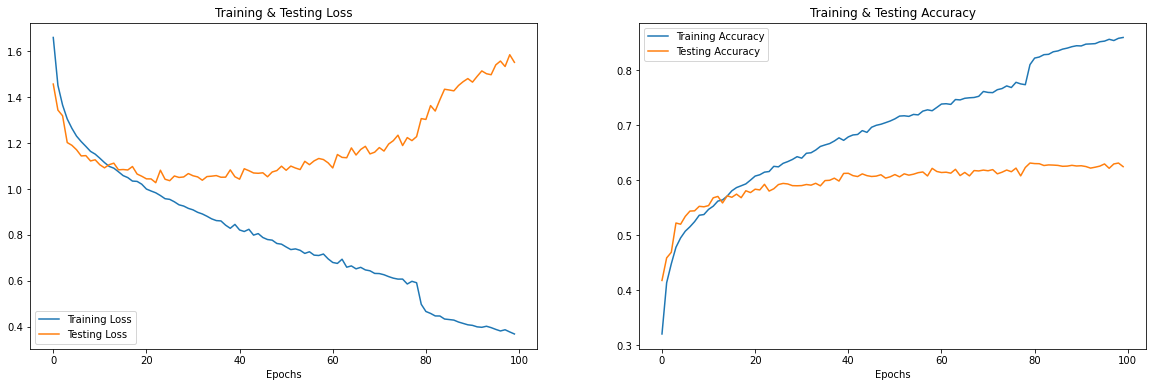

In [132]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# 

### With 50 epochs 

285/285 [==============================] - 12s 40ms/step - loss: 1.0865 - accuracy: 0.6205
Accuracy of our model on test data :  62.050437927246094 %


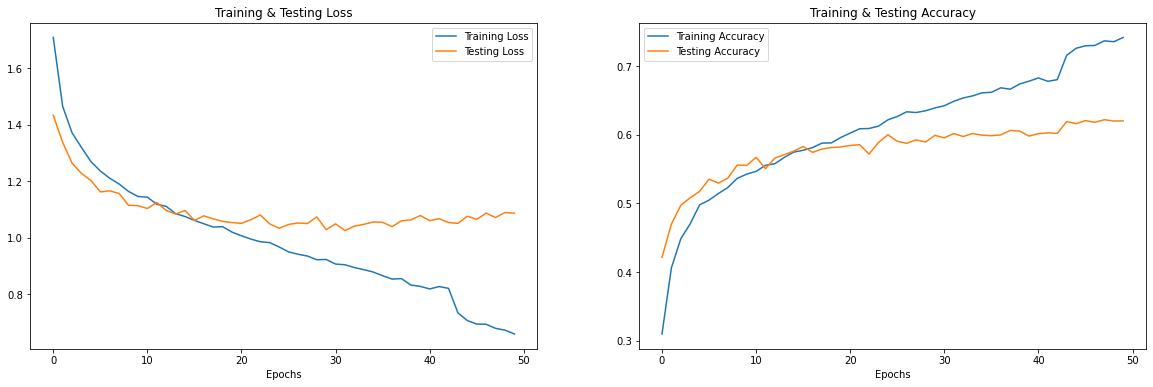

<Figure size 432x288 with 0 Axes>

In [729]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [77]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

285/285 [==============================] - 11s 39ms/step


In [31]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         angry
1            happy         happy
2             fear          fear
3            angry         angry
4            angry         angry
5              sad           sad
6             fear          fear
7          disgust       disgust
8              sad       disgust
9            angry         happy

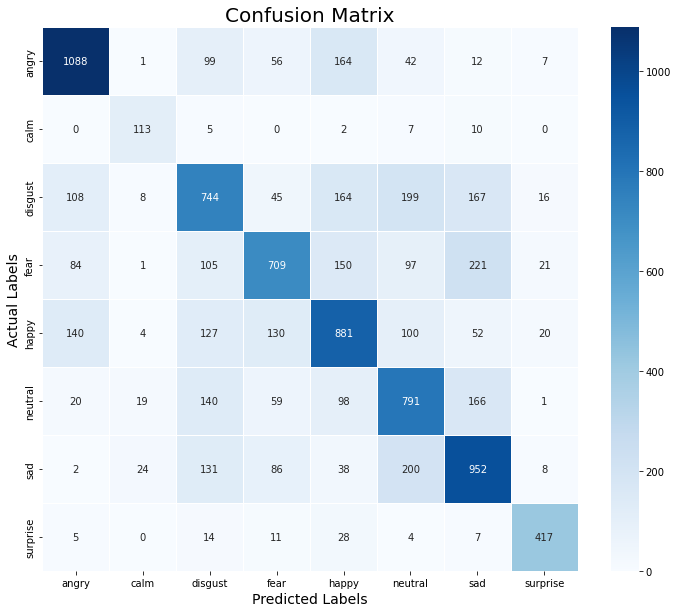

In [79]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.74      0.75      0.75      1469
        calm       0.59      0.85      0.70       137
     disgust       0.54      0.53      0.53      1451
        fear       0.61      0.54      0.57      1388
       happy       0.61      0.52      0.56      1454
     neutral       0.55      0.61      0.58      1294
         sad       0.60      0.67      0.64      1441
    surprise       0.87      0.84      0.86       486

    accuracy                           0.62      9120
   macro avg       0.64      0.66      0.65      9120
weighted avg       0.62      0.62      0.62      9120



# 

# Model Testing on Real-time Data

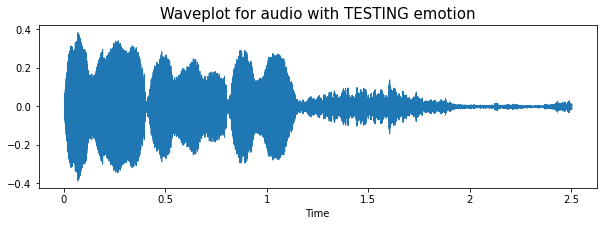

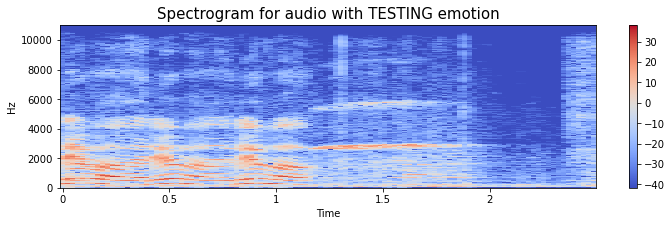

In [122]:
testing = "data/testing/Recording (7).wav"
data, sample_rate = librosa.load(testing, duration=2.5, offset=0.6)
plt.figure(figsize=(10, 3))
plt.title('Waveplot for audio with TESTING emotion', size=15)
librosa.display.waveshow(data, sr=sample_rate)
plt.show()

# stft function converts the data into short term fourier transform
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(12, 3))
plt.title('Spectrogram for audio with TESTING emotion', size=15)
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')   
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

# 

## Predicting Emotion

In [145]:
modell = load_model('model.h5')

In [147]:
testing = "data/testing/Recording.wav"

X = []
feature = get_features(testing)
X.append(feature)

# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
X = scaler.fit_transform(X[0])

Audio(testing)

In [120]:
# predicting on test data.
b = model.predict([X])
pred = encoder.inverse_transform(b)

1/1 [==============================] - 0s 34ms/step


In [121]:
def countFreq(arr, n):
     
    # Mark all array elements as not visited
    visited = [False for i in range(n)]
 
    # Traverse through array elements
    # and count frequencies
    for i in range(n):
         
        # Skip this element if already
        # processed
        if (visited[i] == True):
            continue
 
        # Count frequency
        count = 1
        for j in range(i + 1, n, 1):
            if (arr[i] == arr[j]):
                visited[j] = True
                count += 1
                
        if (np.argmax(b)) <= 7:
            n = 0

        elif (np.argmax(b)) <= 15 & (np.argmax(b)) > 7:
            n = 1
    
        elif (np.argmax(b)) <= 23 & (np.argmax(b)) > 15 :
            n = 2    
        return (arr[n])


print("The recognized emotion is:  " + (countFreq(pred, len(pred)))[0])

The recognized emotion is:  happy


# 

# Thank you!